In [1]:
import run_notebook

In [2]:
import os.path as op

To evaluate a tractography, we need to first have a tractography solution on our hands. If you haven't yet run the [probabilistic tractography notebook](prob_track.ipynb), the following cell will run that notebook for you and generate a file with a set of streamlines in it. This could take a little while, so go get a cup of coffee while this runs.

In [3]:
if not op.exists('prob-track.trk'):
    run_notebook.run_notebook(run_notebook.reads(file('prob_track.ipynb').read(), 'json'))
    
if not op.exists('./det-track.trk'):
    run_notebook.run_notebook(run_notebook.reads(file('det_track.ipynb').read(), 'json'))

In [4]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

import dipy.core.gradients as grad
from dipy.data import get_sphere
from dipy.reconst.csdeconv import auto_response
from dipy.reconst import sfm
from dipy.io.trackvis import save_trk

from IPython.display import display, Image

from dipy.data import (read_stanford_labels,
                       fetch_stanford_t1,
                       read_stanford_t1)

In [5]:
dwi_ni = nib.load(op.join('data', 'SUB1_b2000_1.nii.gz'))
data = dwi_ni.get_data()
affine = dwi_ni.get_affine()
gtab = grad.gradient_table(op.join('data','SUB1_b2000_1.bvals'), op.join('data', 'SUB1_b2000_1.bvecs'))

In [6]:
response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

In [7]:
candidate_prob = [s[0] for s in nib.trackvis.read('prob-track.trk', points_space='voxel')[0]]
candidate_det = [s[0] for s in nib.trackvis.read('det-track.trk', points_space='voxel')[0]]

In [8]:
import dipy.tracking.life as life
fiber_model = life.FiberModel(gtab)

In [9]:
fit_prob = fiber_model.fit(data, candidate_prob, affine=np.eye(4))
fit_det = fiber_model.fit(data, candidate_det, affine=np.eye(4))

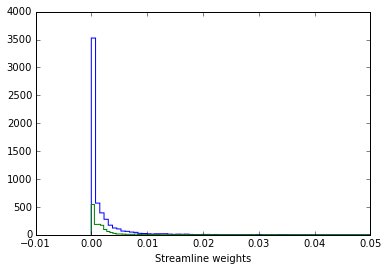

In [10]:
fig, ax = plt.subplots(1)

ax.hist(fit_prob.beta, bins=100, histtype='step')
ax.hist(fit_det.beta, bins=100, histtype='step')
ax.set_xlim([-0.01, 0.05])
ax.set_xlabel('Streamline weights')
ax.set_label('# streamlines')

In [11]:
optimizied_prob = list(np.array(candidate_prob)[np.where(fit_prob.beta>0)[0]])

What proportion of the streamlines survived this culling?

In [12]:
len(optimizied_prob)/float(len(candidate_prob))

0.5242049469964665

In [13]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors
from dipy.data import read_stanford_t1
from dipy.tracking.utils import move_streamlines
from numpy.linalg import inv
t1 = nib.load(op.join('data', 'SUB1_t1_resamp.nii.gz'))
t1_data = t1.get_data()
t1_aff = t1.get_affine()

In [14]:
streamlines_actor = fvtk.streamtube(optimizied_prob,line_colors(optimizied_prob))

In [15]:
vol_actor = fvtk.slicer(t1_data, voxsz=(1.0, 1.0, 1.0), plane_i=[40],
                        plane_j=None, plane_k=[25], outline=False)

ren = fvtk.ren()
fvtk.add(ren, streamlines_actor)
fvtk.add(ren, vol_actor)
fvtk.camera(ren, viewup=(1,0,1), verbose=False)
fvtk.record(ren, out_path='life-prob-track.png', size=(600,600))

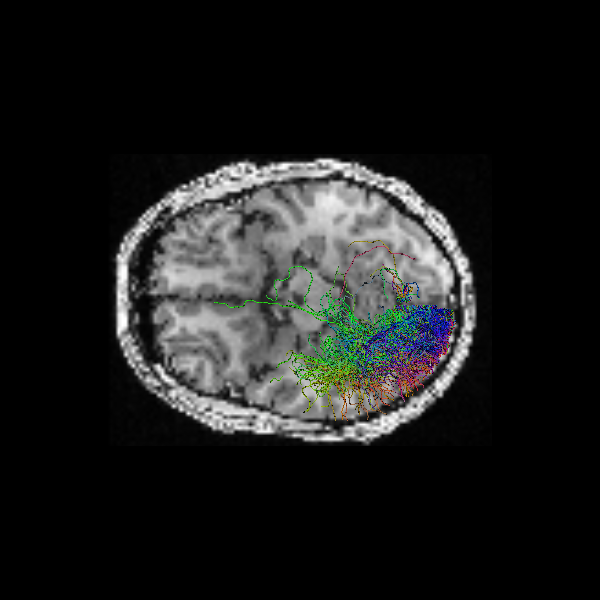

In [16]:
display(Image(filename='life-prob-track.png'))